In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

%matplotlib inline
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torchsample
from torchsample import transforms as ts_transforms
import matplotlib.pyplot as plt
import time
import copy
import os
from PIL import Image
from tensorboard import SummaryWriter
from datetime import datetime

from torchsample.transforms import RangeNorm

import functions.fine_tune as ft

plt.ion()   # interactive mode

/home/mtezcan/anaconda3/lib/python3.6/site-packages/torchsample-0.1.2-py3.6.egg/torchsample/datasets.py:16: UserWarning: Cant import nibabel.. Cant load brain images


Load Data
---------



In [37]:
# Data augmentation and normalization for training 
# Just normalization for validation
dataset_both=True
dataset='real'
uniform_sampler=True
batch_size=32

data_transforms = {
    'train': transforms.Compose([
        transforms.Scale(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        #ts_transforms.RandomRotate(30)
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

if(dataset=='real'):
    data_dir = '..//Data_Sets//pruned//good'
    dsets = {x: datasets.ImageFolder_mtezcan([os.path.join(data_dir, x)], data_transforms[x])
             for x in ['train', 'val']}
    dsets_real = dsets
if(dataset=='synthetic'):
    rootdir='//media//mtezcan//New Volume/HoardingImages//_rated//'
    valdir='//media//mtezcan//New Volume/HoardingImages//_val//validation//House//BR//'
    #subdirs=os.listdir(rootdir)
    subdirs = ['BasicHouse_2017-07-01-rated',
               'BriansHouse_2017-06-30-rated',
               'RuralHome_2017-06-30-rated',
               'SmallApt_2017-06-29-rated']
    roomdirs=['//BR','//Kitchen','//LR']
    '''
    rootdir='//media//mtezcan//New Volume/HoardingImages//_rated//train//'
    valdir='//media//mtezcan//New Volume/HoardingImages//_rated//val//BriansHouse_2017-06-30-rated//LR//'
    subdirs=['BriansHouse_2017-06-30-rated']
    print(subdirs)
    roomdirs=['//LR']
    '''
    dsets = {'train':datasets.ImageFolder_mtezcan([rootdir+subdir+room for subdir in subdirs
                                                   for room in roomdirs], data_transforms['train']),
             'val':datasets.ImageFolder_mtezcan([valdir], data_transforms['val'])}
 
if(uniform_sampler):
    weights,wpc = ft.make_weights_for_balanced_classes(dsets['train'].imgs, len(dsets['train'].classes))  
    weights = torch.DoubleTensor(weights) 
    sampler = {'train':torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights)) ,
               'val':None}
else:
    sampler = {'train':None,
               'val':None}

shuffler={'train':True,'val':False}
dset_loaders = {x:torch.utils.data.DataLoader(dsets[x], batch_size=batch_size,shuffle=shuffler[x],sampler=sampler[x], num_workers=12)
                for x in ['train','val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['train'].classes
print(dset_classes)
use_gpu = torch.cuda.is_available()

if(dataset=='real'):
    dset_loaders_real=dset_loaders
elif(dataset=='synthetic'):
    dset_loaders_synthetic=dset_loaders
#use_gpu=False
if use_gpu:
    print('GPU is available')
else:
    print('!!!!! NO CUDA GPUS DETECTED')

768
768
329
329
['1', '2', '3', '4', '5', '6', '7', '8', '9']
GPU is available


In [28]:
inputs=torch.cat([inputs_real,inputs_synthetic],0)
classes=torch.cat([classes_real,classes_synthetic],0)

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



Size of the input tensors in one batch after grid is  torch.Size([3, 1810, 1810])


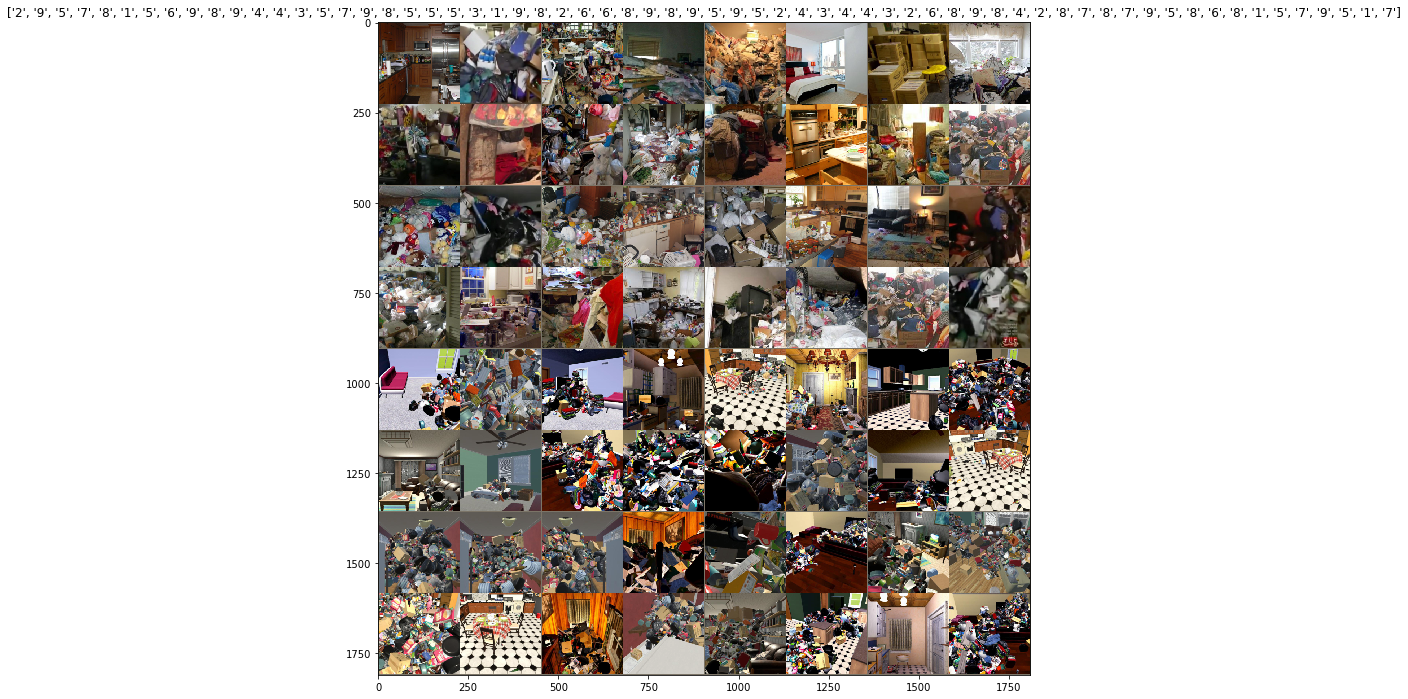

In [29]:

#inputs, classes = next(iter(dset_loaders_real['train']))
#print(classes.cpu().numpy().reshape(4,4)+1)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs,nrow=8)
print('Size of the input tensors in one batch after grid is  '+str(out.size()))
plt.figure(figsize=(12,12))
ft.imshow(out, title=[dset_classes[x] for x in classes])

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [4]:
def writeLog(logname):
    f=open('runs/'+logname+'/Network_properties.txt','w')
    f.write('Dataset: '+dataset+'\n')
    f.write('Network: '+network+'\n')
    f.write('Uniform sampler: '+str(uniform_sampler)+'\n')
    f.write('Criterion: '+criteria+'\n')
    f.write('Learning rate: '+str(lr)+'\n')
    f.write('Momentum: '+str(momentum)+'\n')
    f.write('Leraning Rate Scheduler: '+str(lr_scheduler)+'\n')
    f.write('Leraning Rate Decay Period: '+str(lr_decay_epoch)+'\n')
    f.close()

In [5]:
network='resnet18'
optimizer='sgd'
criteria='multisoft'
lr=0.01
momentum=0.9
weight_decay=0.0005
lr_scheduler=None
lr_decay_epoch=12

if(network=='resnet18'):
    model_ft = models.resnet18(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 9)
elif(network=='alexnet'):
    model_ft = models.alexnet(pretrained=True)
    num_ftrs = model_ft.classifier[6].out_features
    setattr(model_ft.classifier, '7', nn.ReLU(inplace=True))
    setattr(model_ft.classifier, '8', nn.Dropout())
    setattr(model_ft.classifier, '9', nn.Linear(num_ftrs,9))
else:
    raise ValueError('Undefined network '+network)

if use_gpu:
    model_ft = model_ft.cuda()

if(criteria=='crossentropy'):
    criterion = nn.CrossEntropyLoss()
elif(criteria=='multisoft'):
    criterion=nn.MultiLabelSoftMarginLoss()
else:
    raise ValueError('Undefined criteria '+criteria)
    
if(optimizer=='adam'):
    optimizer_ft = optim.Adam(model_ft.parameters(),lr=lr,weight_decay=weight_decay)
elif(optimizer=='sgd'):
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=momentum,weight_decay=weight_decay)


In [6]:
logname=network+'_'+optimizer+'_'+criteria+'_'+datetime.now().strftime('%B%d  %H:%M:%S')
writer = SummaryWriter('runs/'+logname)
writeLog(logname)
if(uniform_sampler):
    model_ft = ft.train_model_balanced(model_ft, criterion, optimizer_ft, lr_scheduler,dset_loaders,dset_sizes,writer,
                            use_gpu=use_gpu,num_epochs=50,batch_size=batch_size,num_train=15,num_test=2,multilabel=True,
                              multi_prob=False,lr_decay_epoch=lr_decay_epoch,init_lr=lr)
else:
    model_ft = ft.train_model(model_ft, criterion, optimizer_ft, lr_scheduler,dset_loaders,dset_sizes,writer,
                        use_gpu=use_gpu,num_epochs=50,batch_size=batch_size,num_log=200,multilabel=True,
                          multi_prob=False,lr_decay_epoch=lr_decay_epoch,init_lr=lr)


Epoch 0/49
----------
1/2, Loss: 0.0098 Acc: 0.1521 CIR-1: 0.4156
2/2, Loss: 0.0075 Acc: 0.2750 CIR-1: 0.7052
Val Loss: 0.0087 Acc: 0.2644 CIR-1: 0.6869

Epoch 1/49
----------
1/2, Loss: 0.0065 Acc: 0.2729 CIR-1: 0.7604
2/2, Loss: 0.0056 Acc: 0.3281 CIR-1: 0.8427
Val Loss: 0.0074 Acc: 0.3070 CIR-1: 0.7568

Epoch 2/49
----------
1/2, Loss: 0.0052 Acc: 0.3417 CIR-1: 0.8677
2/2, Loss: 0.0048 Acc: 0.3448 CIR-1: 0.8750
Val Loss: 0.0070 Acc: 0.3435 CIR-1: 0.7964

Epoch 3/49
----------
1/2, Loss: 0.0043 Acc: 0.3625 CIR-1: 0.9208
2/2, Loss: 0.0040 Acc: 0.3844 CIR-1: 0.9344
Val Loss: 0.0069 Acc: 0.3404 CIR-1: 0.8298

Epoch 4/49
----------
1/2, Loss: 0.0036 Acc: 0.4177 CIR-1: 0.9354
2/2, Loss: 0.0034 Acc: 0.4417 CIR-1: 0.9437
Val Loss: 0.0065 Acc: 0.3556 CIR-1: 0.8359

Epoch 5/49
----------
1/2, Loss: 0.0032 Acc: 0.4479 CIR-1: 0.9531
2/2, Loss: 0.0029 Acc: 0.4740 CIR-1: 0.9677
Val Loss: 0.0067 Acc: 0.3769 CIR-1: 0.8450

Epoch 6/49
----------


Process Process-2304:
Process Process-2296:
Process Process-2298:
Process Process-2297:
Process Process-2295:
Process Process-2303:
Traceback (most recent call last):
  File "/home/mtezcan/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process Process-2293:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-2299:
Process Process-2300:
Process Process-2301:
  File "/home/mtezcan/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Process Process-2294:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtezcan/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/mtezcan/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process Process-2302:


KeyboardInterrupt: 

In [ ]:
torch.save(model_ft,'./saved_models/'+logname)
model_ft_backup=model_ft

In [ ]:
#model_ft=torch.load('./Obsolete/saved_models/resnet18_multi_88_real_7_15_17.mdl')
model_ft=torch.load('./saved_models/resnet_real_ft5s_multisoft__1300_100epoch_July19  12:22:17')
if use_gpu:
    model_ft = model_ft.cuda()

#criterion = nn.CrossEntropyLoss()
criterion=nn.MultiLabelSoftMarginLoss()
# Observe that all parameters are being optimized
#optimizer_ft = optim.Adam(model_ft.parameters())
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
model_ft = model_ft.cuda()
print(model_ft)

# --- to-be-optimized ---

In [ ]:
#print(next(iter(dset_loaders['train']))[0])
#model_ft = models.alexnet(pretrained=True)

model_ft=model_ft.cpu()
model_ft.train(False)
#new_classifier = nn.Sequential(*list(model_ft.classifier.children())[:-5])
#model_ft.classifier = new_classifier
#print(model_ft)
model_params= list(model_ft.children())
#model_params[1]=list(model_params[1])
#print(model_params)
new_ft = nn.Sequential(*list(model_params)[:-1])
#print(new_ft)

fvec_tr=np.zeros((20000,512))
label_tr=np.zeros((20000))

fvec_val=np.zeros((20000,512))
label_val=np.zeros((20000))
count=0;

#inputs_t, classes_t = data=next(iter(dset_loaders['train']))
#print(inputs_t.size())
#fvec_t=new_ft(Variable(inputs_t))

for data in dset_loaders['train']:
    inputs_t, classes_t = data
    fvec_t=new_ft(Variable(inputs_t))
    #print(fvec_t)
    fvec_t_cpu=fvec_t.cpu()
    if(fvec_t_cpu.data.numpy().shape[0]==4):
        fvec_tr[count:count+4,:]=fvec_t_cpu.data.numpy().reshape(4,-1)
        label_tr[count:count+4]=classes_t.short().numpy()
        count +=4
fvec_tr=fvec_tr[:count,:]
label_tr=label_tr[:count]


count=0;
for data in dset_loaders['val']:
    inputs_t, classes_t = data
    fvec_t=new_ft(Variable(inputs_t))
    fvec_t_cpu=fvec_t.cpu()
    if(fvec_t_cpu.data.numpy().shape[0]==4):
        fvec_val[count:count+4,:]=fvec_t_cpu.data.numpy().reshape(4,-1)
        label_val[count:count+4]=classes_t.short().numpy()
        count +=4
    
fvec_val=fvec_val[:count,:]
label_val=label_val[:count]

'''
print('The CNN model is')
print(model_ft)
num_ftrs = model_ft.classifier[6].in_features
print('Number of features in the fine tune layer is '+str(num_ftrs))
setattr(model_ft.classifier, '6', nn.Linear(num_ftrs, 9))
#model_ft.classifier['6'] = nn.Linear(num_ftrs, 2)
print(model_ft)
'''

print('Size of the input in training is '+str(fvec_tr.shape))
print('Size of the labels in training is '+str(label_tr.shape))

print('Size of the input in validation is '+str(fvec_val.shape))
print('Size of the labels in validation is '+str(label_val.shape))


In [ ]:
print(fvec_val.shape)
print(fvec_val[1,:])

In [ ]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
#clf = SVC(C=1,kernel='linear',class_weight='balanced',decision_function_shape='ovo')
clf=OneVsOneClassifier(LinearSVC(C=1e-5))
clf.fit(fvec_tr,label_tr)
label_pred=clf.predict(fvec_val)
abs_err=np.abs(label_pred-label_val)
cir1=np.mean(abs_err<=1)
print(cir1)

In [ ]:
from sklearn.svm import SVC

c_val=np.power(2,np.arange(0.,8.,1.))
g_val=np.power(2,np.arange(-10.,-5.,1.))

#c_val=[128]
#g_val=[np.power(2,-10.)]
cir1_max=0.
c_max=0
g_max=0
for c_1 in c_val:
    for g in g_val:
        
        clf_svc = SVC(C=c_1,kernel='rbf',gamma=g,shrinking=False,class_weight='balanced')
        clf=OneVsOneClassifier(clf_svc)
        #print(label_tr)
        clf.fit(fvec_tr,label_tr)

        label_pred=clf.predict(fvec_val)
        #print(label_pred)
        abs_err=np.abs(label_pred-label_val)
        #print(abs_err)
        cir1=np.mean(abs_err<=1)
        print('C = '+str(c_1),', g = ',str(g),', cir-1 = '+str(cir1))
        if(cir1>cir1_max):
            cir1_max=cir1
            c_max=c_1
            g_max=g
            

clf = SVC(C=c_max,kernel='rbf',gamma=g_max)#,class_weight='balanced')
clf.fit(fvec_tr,label_tr)
label_pred=clf.predict(fvec_val)
abs_err=np.abs(label_pred-label_val)
print('Max CIR-1 achieved is '+str(np.mean(abs_err<=1)) +' with c='+str(c_max),', g='+str(g_max))
print('CIR-0 = '+str(np.mean(abs_err<=0)))
print('CIR-2 = '+str(np.mean(abs_err<=2)))
tr_pred=clf.predict(fvec_tr)
abs_tr=np.abs(tr_pred-label_tr)
print('Training CIR-1 is '+str(np.mean(abs_tr<=1)))
#print(abs_err)
#print(label_val)

In [ ]:
model_ft = models.resnet18(pretrained=True)

#print('The CNN model is')
#print(model_ft)
#print(list(model_ft.children())[:-1])
num_ftrs = model_ft.fc.in_features
print('Number of features in the fine tune layer is '+str(num_ftrs))
#setattr(model_ft.classifier, '6', nn.Linear(num_ftrs, 9))
model_ft.fc = nn.Linear(num_ftrs, 9)
#print(model_ft)

#print(next(iter(dset_loaders['train']))[0])
new_ft = nn.Sequential(*list(model_ft.children())[:-1])
#dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=4,
#                                               shuffle=True, num_workers=4)
#                for x in ['train', 'val']}

fvec_tr=np.zeros((X_tr.shape[0],512))
for k in range(0,10,10):#(0,inputs.shape[0],10):
    print(k)
    fvec_now=new_ft(Variable(torch.from_numpy(X_tr[k:k+10,:,:,:])))
    print(fvec_now.numpy())

print(fvec)


'''
print('The CNN model is')
print(model_ft)
num_ftrs = model_ft.classifier[6].in_features
print('Number of features in the fine tune layer is '+str(num_ftrs))
setattr(model_ft.classifier, '6', nn.Linear(num_ftrs, 9))
#model_ft.classifier['6'] = nn.Linear(num_ftrs, 2)
print(model_ft)
'''

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [ ]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    #print(param)
    param.requires_grad = False
    
for param in model_conv.fc.parameters():
    #print(param)
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 9)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv = ft.train_model(model_conv, criterion, optimizer_conv, ft.exp_lr_scheduler,dset_loaders,dset_sizes,writer,
                        use_gpu=use_gpu,num_epochs=100,batch_size=32,num_log=1000,multilabel=False,multi_prob=False,
                         lr_decay_epoch=7)

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()